In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import statsmodels.api as sm
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
class ColorForPrint:
    BOLD = '\033[1m'
    END = '\033[0m'

In [3]:
# Loading the dataset
BoomBikesDF = pd.read_csv('day.csv')
BoomBikesDF.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
BoomBikesDF.shape

(730, 16)

In [5]:
class DataUnderstanding:
    def __init__(self, BikesDF):
        self.BikesDF = BikesDF
    # This is a custom function providing an alternative for df.info() and df.describe()
    def dataDescription(self):
        print("Total number values are", self.BikesDF.size)
        print("Loan Data set has", self.BikesDF.shape[0], "rows and", self.BikesDF.shape[1], "columns")
        print("Number of dimensions are", self.BikesDF.ndim) # as it is a DataFrame
        print()
        DataTypes = self.BikesDF.dtypes.value_counts()
        print("There are", len(DataTypes), "datatypes in the data set",)
        print(DataTypes)
        print()
        print(ColorForPrint.BOLD,"Mean of Dataset ", ColorForPrint.END)
        print(self.BikesDF.mean().sort_values(ascending = False).head(20))
        print()
        print(ColorForPrint.BOLD,"Median of Dataset ", ColorForPrint.END)
        print(self.BikesDF.median().sort_values(ascending = False).head(20))
        print()
        print(ColorForPrint.BOLD,"Standard deviation of Dataset ", ColorForPrint.END)
        print(self.BikesDF.std().sort_values(ascending = False).head(20))
        print()
        print(ColorForPrint.BOLD,"Minumum Value of Dataset ", ColorForPrint.END)
        print(self.BikesDF.min().head(20))
        print()
        print(ColorForPrint.BOLD,"Maximum Value of Dataset ", ColorForPrint.END)
        print(self.BikesDF.max().head(20))
        print()
        print(ColorForPrint.BOLD,"25% of Dataset ", ColorForPrint.END)
        print(self.BikesDF.quantile(0.25).sort_values(ascending = False).head(20))
        print()
        print(ColorForPrint.BOLD, "50% of Dataset ", ColorForPrint.END)
        print(self.BikesDF.quantile(0.50).sort_values(ascending = False).head(20))
        print()
        print(ColorForPrint.BOLD, "75% of Dataset ", ColorForPrint.END)
        print(self.BikesDF.quantile(0.75).sort_values(ascending = False).head(20))
        print()
        print(ColorForPrint.BOLD, "Total number of Null Values ", ColorForPrint.END)
        NullDF = (self.BikesDF.isnull().sum().sort_values(ascending = False)).to_frame()
        NullDF.columns = ['NullValues']
        NullValuesCount = NullDF[NullDF['NullValues'] == "True"].count()[0]
        if NullValuesCount > 0:
            print("We can see that there are",NullValuesCount, "null value columns so we have to remove it.")
        else:
            print("There are no columns with all values as null values.")
        print()
    
    # Detect continuous and categorical variable.
    def detectContinuousCategorical(self):
        continuous_variables = []
        categorical_variables = []
        for column in self.BikesDF.columns:
            Category = len(self.BikesDF[column].value_counts())
            print(column,":",Category)
            if Category > 10:
                continuous_variables.append(column)
            else:
                categorical_variables.append(column)
        return continuous_variables, categorical_variables
    # Plot correlation matrix
    def plotCorrelationMatrix(self):
        plt.figure(figsize=(17,17))
        sb.heatmap(self.BikesDF.corr(), annot = True, cbar = False)
        plt.tight_layout()
        plt.show()
    # Get heat index values for 
    def heatIndexValues(self):
        temp = self.BikesDF['temp']
        hum = self.BikesDF['hum']
        # Convert celius to fahrenheit (heat-index is only fahrenheit compatible)
        fahrenheit = ((temp * 9/5) + 32)
        # Creating multiples of 'fahrenheit' & 'hum' values for the coefficients
        T2 = pow(fahrenheit, 2)
        T3 = pow(fahrenheit, 3)
        H2 = pow(hum, 2)
        H3 = pow(hum, 3)
        HeatIndexValues = pd.Series([])
        # C1 refers to the coefficients we are taking
        C1 = [ -42.379, 2.04901523, 10.14333127, -0.22475541, -6.83783e-03, -5.481717e-02, 1.22874e-03, 8.5282e-04, -1.99e-06]
        for val in range(len(self.BikesDF['temp'])-1):
            heatindex = C1[0] + (C1[1] * fahrenheit[val]) + (C1[2] * hum[val]) + (C1[3] * fahrenheit[val] * hum[val]) + (C1[4] * T2[val]) + (C1[5] * H2[val]) + (C1[6] * T2[val] * hum[val]) + (C1[7] * fahrenheit[val] * H2[val]) + (C1[8] * T2[val] * H2[val])
            HeatIndexValues[val] = round(heatindex, 4)
        return HeatIndexValues
    def linearRegressionModelCheck(self, columns, y_BoomBikes_train):
        X_BoomBikes_train_sm = sm.add_constant(self.BikesDF[columns])
        lr = sm.OLS(y_BoomBikes_train, X_BoomBikes_train_sm)
        lr_Model  = lr.fit()
        print(ColorForPrint.BOLD,"Model Summary ", ColorForPrint.END)
        print(lr_Model.summary())
        print()
        print()
        print()
    # Clean unwanted data having high correlation. 
    def dataCleaningAndAddition(self):
        self.BikesDF = self.BikesDF.drop(columns = ['instant', 'dteday','casual', 'registered', 'atemp'])
        seasonDummies = pd.get_dummies(self.BikesDF['season'], prefix= "season", prefix_sep = " ", drop_first= True)
        weathersitDummies  = pd.get_dummies(self.BikesDF['weathersit'], prefix= "weathersit", prefix_sep = " ", drop_first= True)
        monthDummies  = pd.get_dummies(self.BikesDF['mnth'], prefix= "month", prefix_sep = " ", drop_first= True)
        self.BikesDF = pd.concat([self.BikesDF, seasonDummies, weathersitDummies, monthDummies], axis = 1)
        heatindex = self.heatIndexValues()
        self.BikesDF['heatindex'] = heatindex
        self.BikesDF = self.BikesDF.fillna(0)
        return self.BikesDF

In [6]:
# We are using the concept of object as dataframes
obj = DataUnderstanding(BoomBikesDF)

In [7]:
BoomBikesNullDFCount= pd.DataFrame(BoomBikesDF.isnull().all())
BoomBikesNullDFCount

,0
instant,False
dteday,False
season,False
yr,False
mnth,False
holiday,False
weekday,False
workingday,False
weathersit,False
temp,False


In [8]:
obj.dataDescription()

Total number values are 11680
Loan Data set has 730 rows and 16 columns
Number of dimensions are 2

There are 3 datatypes in the data set
int64      11
float64     4
object      1
dtype: int64

 Mean of Dataset  
cnt           4508.006849
registered    3658.757534
casual         849.249315
instant        365.500000
hum             62.765175
atemp           23.726322
temp            20.319259
windspeed       12.763620
mnth             6.526027
weekday          2.997260
season           2.498630
weathersit       1.394521
workingday       0.683562
yr               0.500000
holiday          0.028767
dtype: float64

 Median of Dataset  
cnt           4548.500000
registered    3664.500000
casual         717.000000
instant        365.500000
hum             62.625000
atemp           24.368225
temp            20.465826
windspeed       12.125325
mnth             7.000000
season           3.000000
weekday          3.000000
workingday       1.000000
weathersit       1.000000
yr               0.500

In [9]:
continuous, categorical = obj.detectContinuousCategorical()

instant : 730
dteday : 730
season : 4
yr : 2
mnth : 12
holiday : 2
weekday : 7
workingday : 2
weathersit : 3
temp : 498
atemp : 689
hum : 594
windspeed : 649
casual : 605
registered : 678
cnt : 695


In [10]:
categorical

['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit']

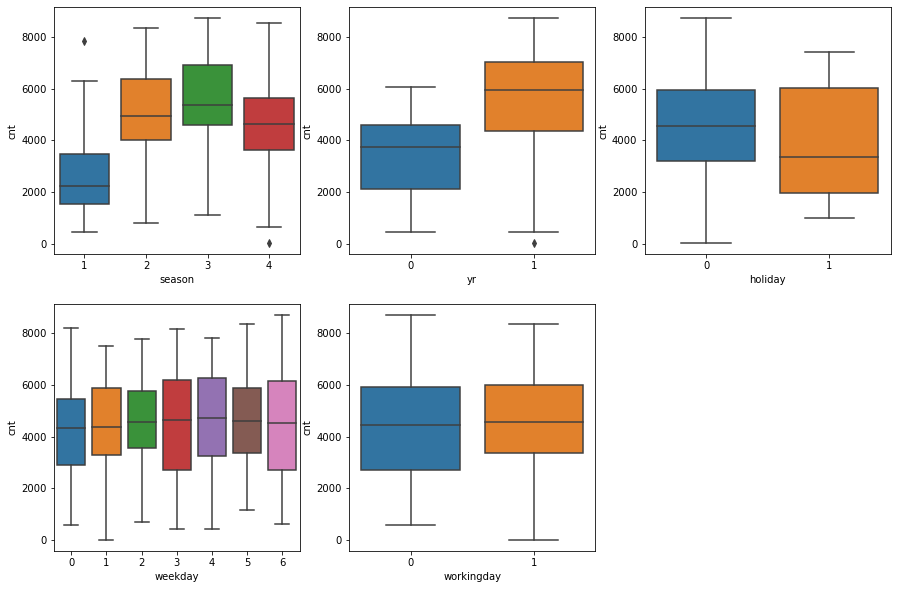

In [11]:
# Check how the independent variable changes with respect to the target variable and check for outliers if any. 
plt.figure(figsize=(15, 10))
for i in range(len(categorical) -1):
    plt.subplot(2,3,i+1)
    sb.boxplot(x = categorical[i], y = 'cnt', data = BoomBikesDF)

plt.show()

There are outliers in season and year but due to the small dataset, it is wise to not remove the outliers. 

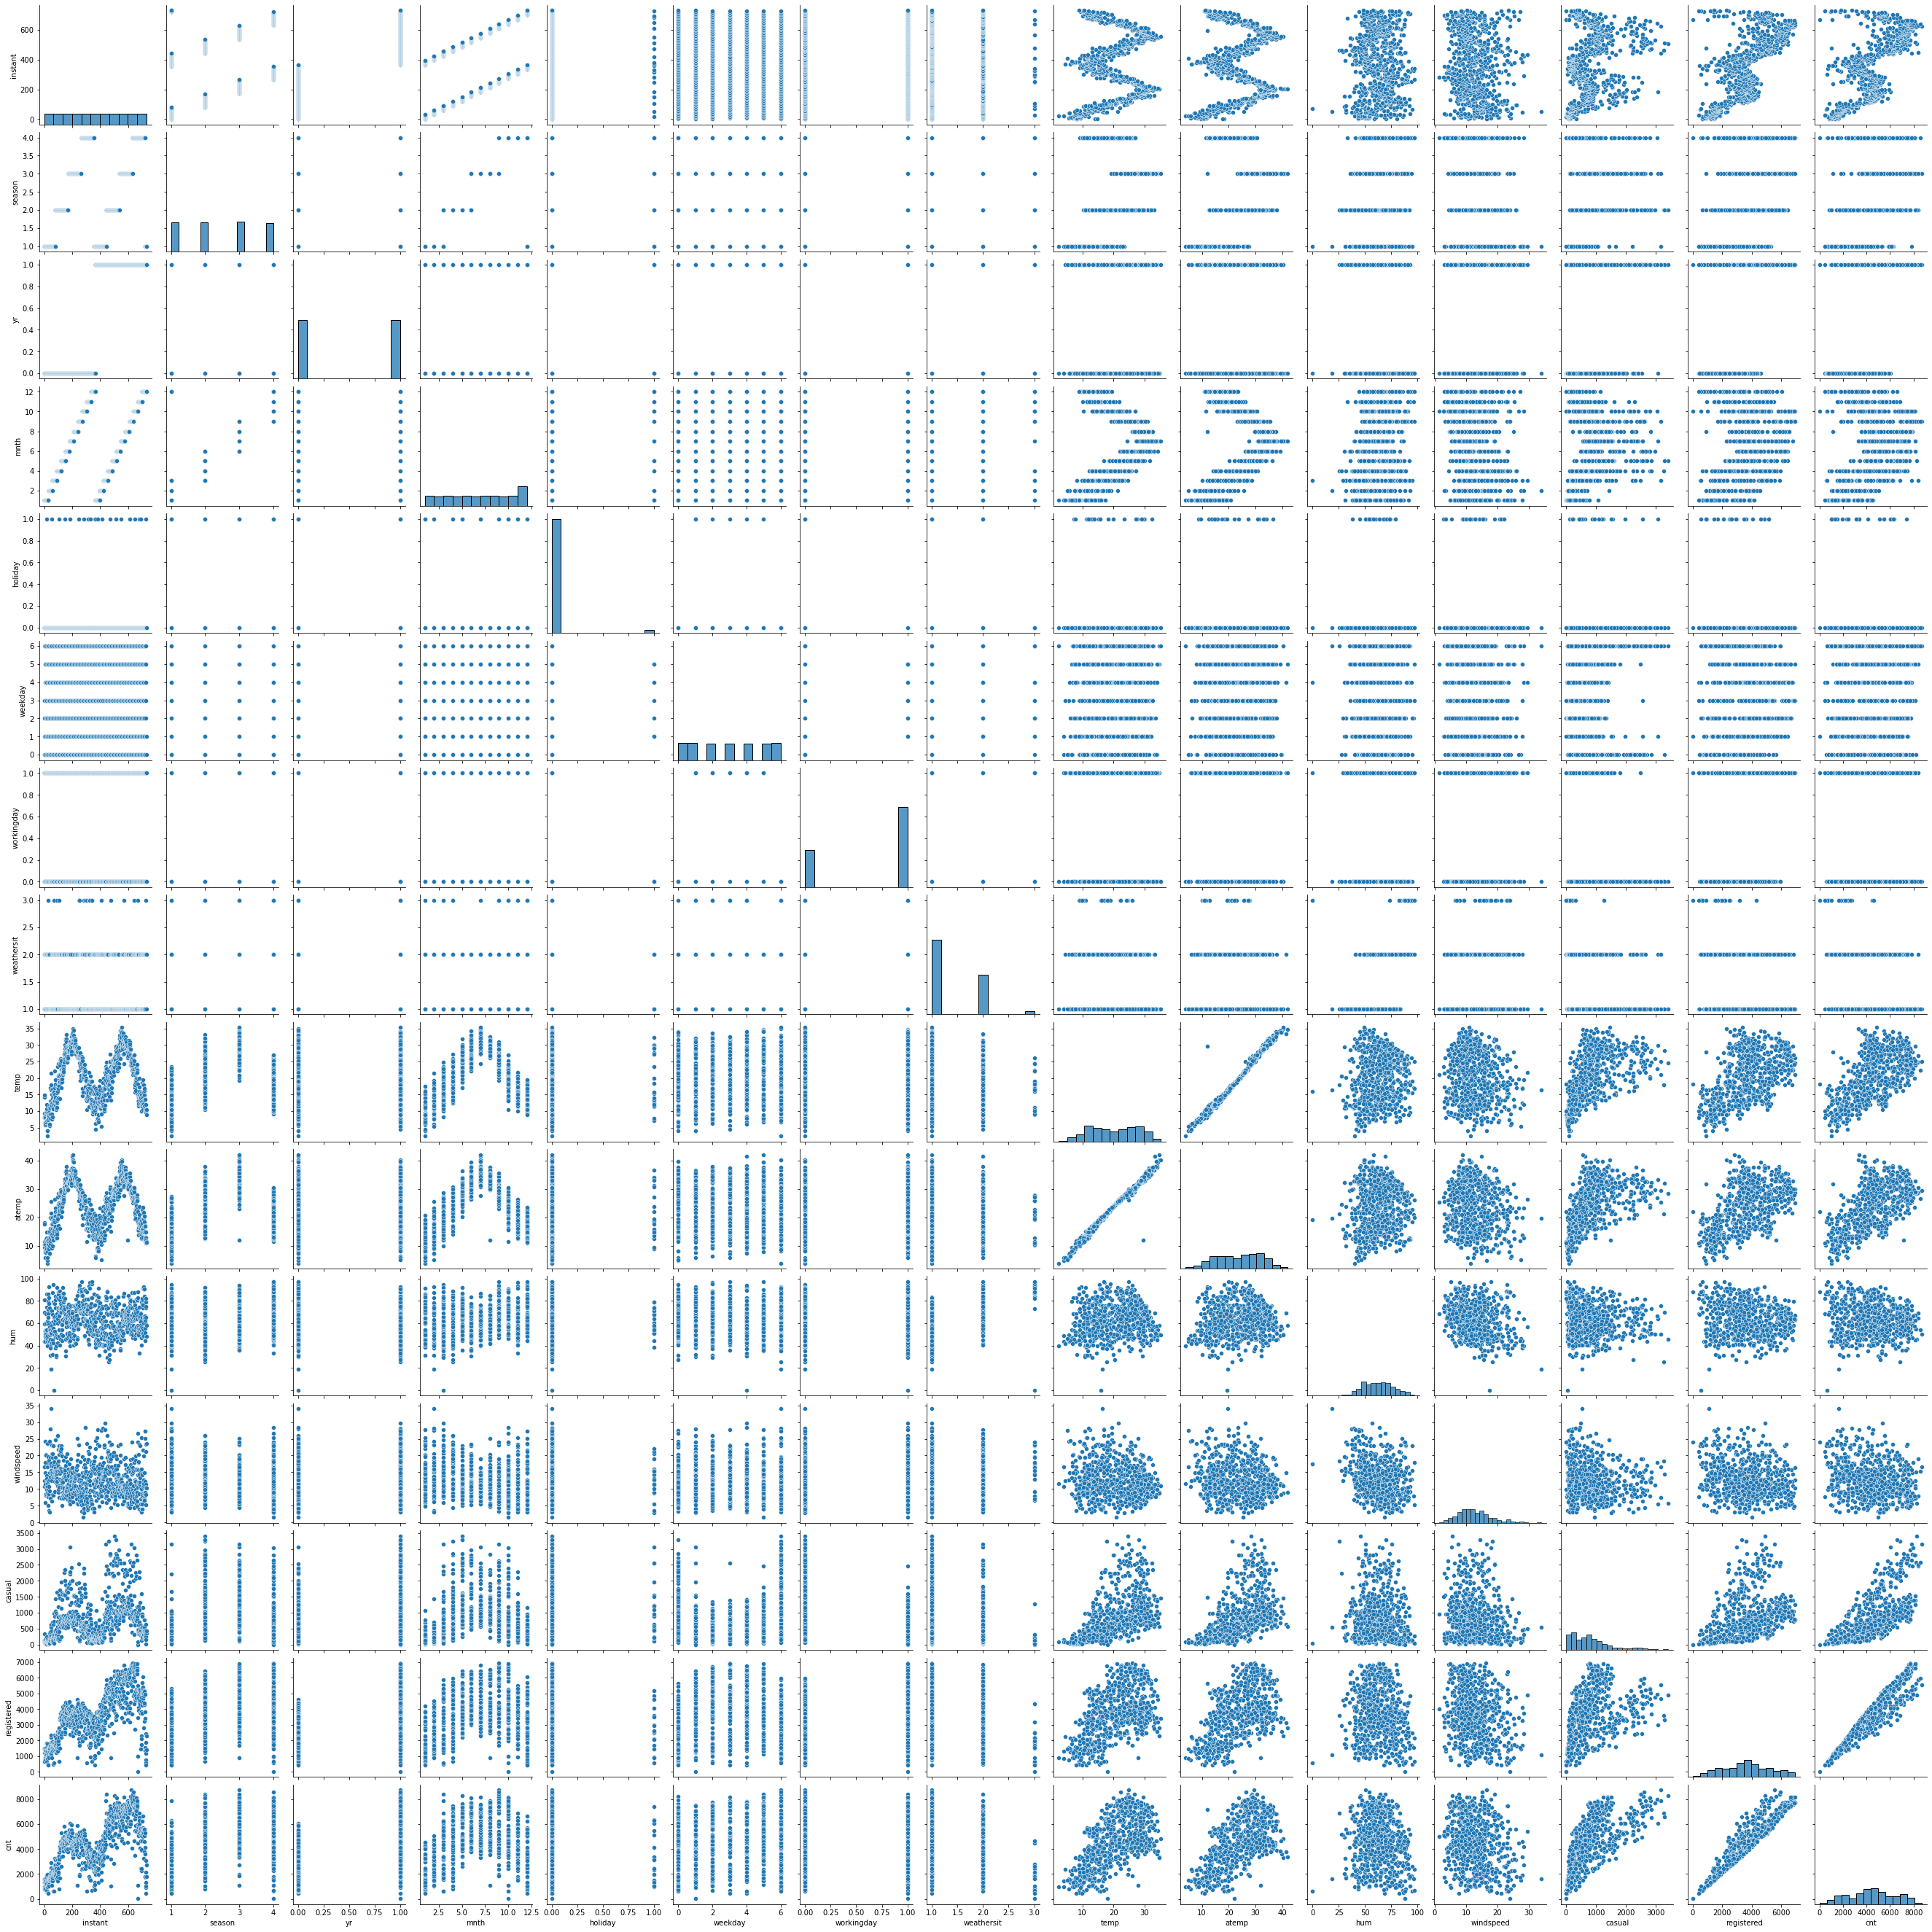

In [12]:
sb.pairplot(BoomBikesDF)

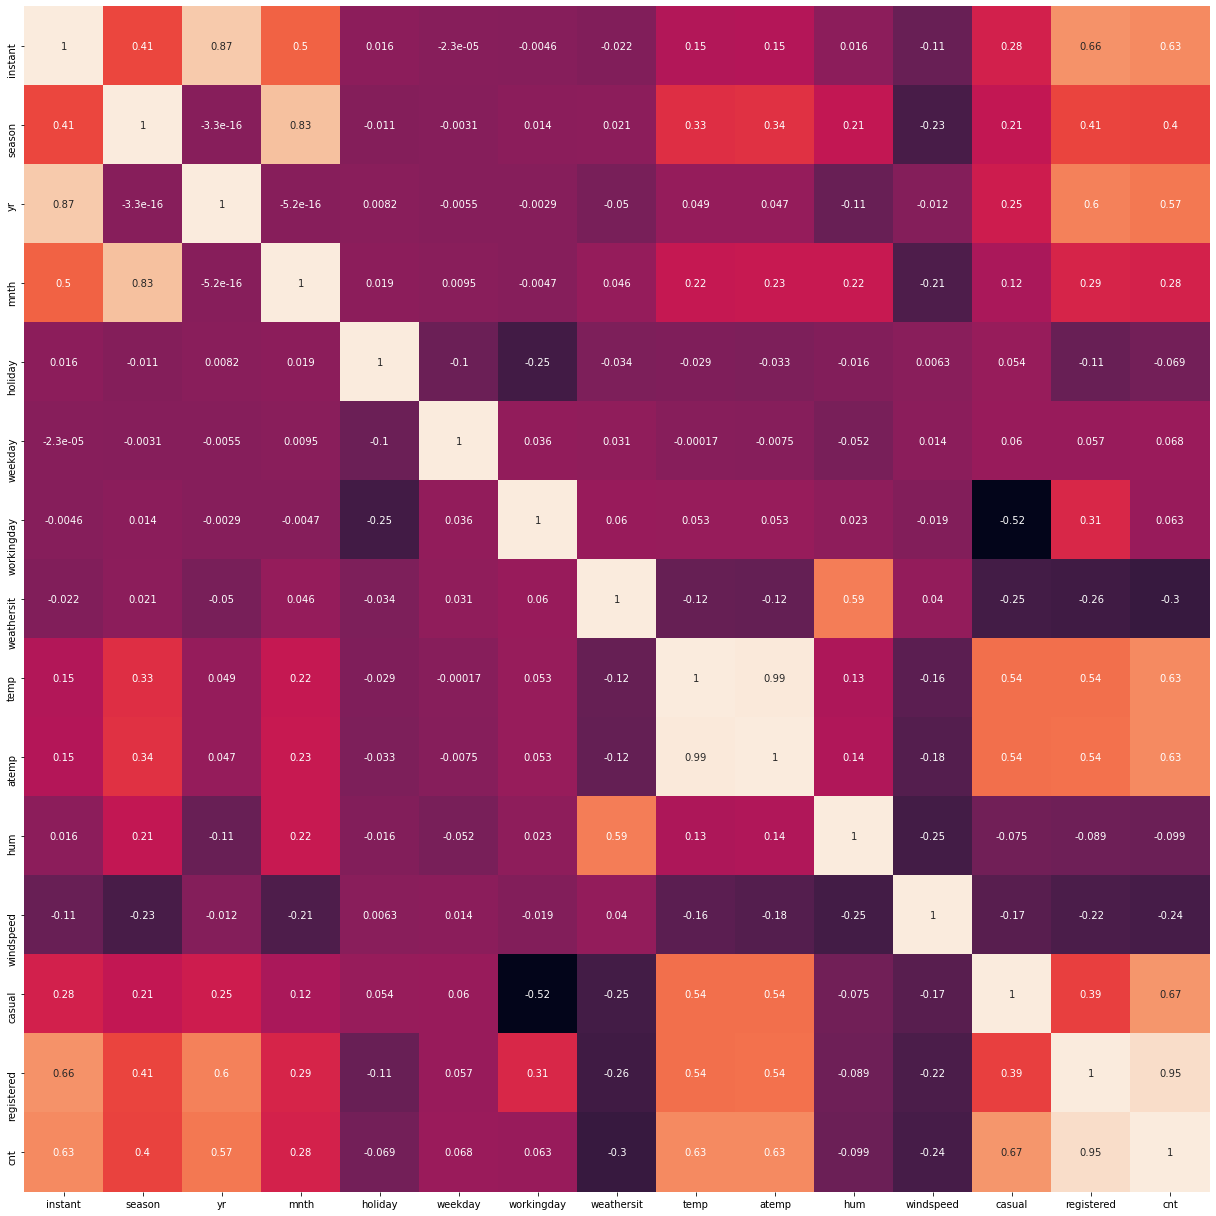

In [13]:
obj.plotCorrelationMatrix()

We can analyze that "year" is highly correlated with "holiday", "instant", "season" is highly correlated with "month", "temp" is highly correlated with "atemp". "registered" is highly correlated with "cnt"."cnt" is highly correlated with instant, dteday, temp, atemp, casual, registered, cnt.

In [14]:
obj = DataUnderstanding(BoomBikesDF)
BoomBikesDF = obj.dataCleaningAndAddition()
BoomBikesDF

<ipython-input-5-ea2d65cdc509>:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  HeatIndexValues = pd.Series([])


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,...,month 4,month 5,month 6,month 7,month 8,month 9,month 10,month 11,month 12,heatindex
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,...,0,0,0,0,0,0,0,0,0,76.0575
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,...,0,0,0,0,0,0,0,0,0,80.3169
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,...,0,0,0,0,0,0,0,0,0,103.6340
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,...,0,0,0,0,0,0,0,0,0,108.2378
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,...,0,0,0,0,0,0,0,0,0,99.0007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,1,12,0,4,1,2,10.420847,65.2917,23.458911,...,0,0,0,0,0,0,0,0,1,97.1139
726,1,1,12,0,5,1,2,10.386653,59.0000,10.416557,...,0,0,0,0,0,0,0,0,1,98.3203
727,1,1,12,0,6,0,2,10.386653,75.2917,8.333661,...,0,0,0,0,0,0,0,0,1,92.8596
728,1,1,12,0,0,0,1,10.489153,48.3333,23.500518,...,0,0,0,0,0,0,0,0,1,96.7333


In [15]:
obj = DataUnderstanding(BoomBikesDF)
heatindex = obj.heatIndexValues()
BoomBikesDF['heatindex'] = heatindex
obj = DataUnderstanding(BoomBikesDF)
BoomBikesDF = BoomBikesDF.fillna(0)

<ipython-input-5-ea2d65cdc509>:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  HeatIndexValues = pd.Series([])


In [16]:
continuous, categorical = obj.detectContinuousCategorical()
continuous

season : 4
yr : 2
mnth : 12
holiday : 2
weekday : 7
workingday : 2
weathersit : 3
temp : 498
hum : 594
windspeed : 649
cnt : 695
season 2 : 2
season 3 : 2
season 4 : 2
weathersit 2 : 2
weathersit 3 : 2
month 2 : 2
month 3 : 2
month 4 : 2
month 5 : 2
month 6 : 2
month 7 : 2
month 8 : 2
month 9 : 2
month 10 : 2
month 11 : 2
month 12 : 2
heatindex : 728


['mnth', 'temp', 'hum', 'windspeed', 'cnt', 'heatindex']

In [17]:
BoomBikesDF

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,...,month 4,month 5,month 6,month 7,month 8,month 9,month 10,month 11,month 12,heatindex
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,...,0,0,0,0,0,0,0,0,0,76.0575
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,...,0,0,0,0,0,0,0,0,0,80.3169
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,...,0,0,0,0,0,0,0,0,0,103.6340
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,...,0,0,0,0,0,0,0,0,0,108.2378
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,...,0,0,0,0,0,0,0,0,0,99.0007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,1,12,0,4,1,2,10.420847,65.2917,23.458911,...,0,0,0,0,0,0,0,0,1,97.1139
726,1,1,12,0,5,1,2,10.386653,59.0000,10.416557,...,0,0,0,0,0,0,0,0,1,98.3203
727,1,1,12,0,6,0,2,10.386653,75.2917,8.333661,...,0,0,0,0,0,0,0,0,1,92.8596
728,1,1,12,0,0,0,1,10.489153,48.3333,23.500518,...,0,0,0,0,0,0,0,0,1,96.7333


In [18]:
BoomBikes_train, BoomBikes_test = train_test_split(BoomBikesDF, test_size=0.3, random_state = 300)
minMaxScaleObj = MinMaxScaler()
# Min Max Scaling is prefferd for continuous variables. 
numericalsVars =  ['temp', 'hum', 'windspeed','cnt']
BoomBikes_train[numericalsVars] = minMaxScaleObj.fit_transform(BoomBikes_train[numericalsVars])
y_BoomBikes_train = BoomBikes_train.pop('cnt')
X_BoomBikes_train = BoomBikes_train

<ipython-input-18-e9c59f9ad94e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BoomBikes_train[numericalsVars] = minMaxScaleObj.fit_transform(BoomBikes_train[numericalsVars])
C:\Users\nithy\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [19]:
BoomBikes_train.shape

(511, 27)

In [20]:
X_BoomBikes_train.shape

(511, 27)

In [21]:
y_BoomBikes_train

337    0.398412
547    0.713875
626    0.870801
309    0.417280
561    0.783249
         ...   
725    0.240681
9      0.149448
714    0.433042
481    0.714565
209    0.439945
Name: cnt, Length: 511, dtype: float64

In [22]:
print(ColorForPrint.BOLD,"X_BoomBikes_train ", ColorForPrint.END)
print(X_BoomBikes_train.head())
print()
print(ColorForPrint.BOLD,"y_BoomBikes_train ", ColorForPrint.END)
print(y_BoomBikes_train.head())

 X_BoomBikes_train  
     season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
337       4   0    12        0        0           0           1  0.348693   
547       3   1     7        0        1           1           1  0.927277   
626       3   1     9        0        3           1           1  0.633172   
309       4   0    11        0        0           0           1  0.371152   
561       3   1     7        0        1           1           1  0.903748   

          hum  windspeed  ...  month 4  month 5  month 6  month 7  month 8  \
337  0.799484   0.146877  ...        0        0        0        0        0   
547  0.460712   0.412422  ...        0        0        0        1        0   
626  0.553027   0.459915  ...        0        0        0        0        0   
309  0.756977   0.166191  ...        0        0        0        0        0   
561  0.664663   0.338275  ...        0        0        0        1        0   

     month 9  month 10  month 11  month 12  hea

In [23]:
X_BoomBikes_train.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'season 2', 'season 3',
       'season 4', 'weathersit 2', 'weathersit 3', 'month 2', 'month 3',
       'month 4', 'month 5', 'month 6', 'month 7', 'month 8', 'month 9',
       'month 10', 'month 11', 'month 12', 'heatindex'],
      dtype='object')

In [24]:
BoomBikesVIFDF = pd.DataFrame()
BoomBikesVIFDF["Features"] = X_BoomBikes_train.columns
  
# calculating VIF for each feature
BoomBikesVIFDF["Variance Inflation Factor"] = [variance_inflation_factor(X_BoomBikes_train.values, i)
                          for i in range(len(X_BoomBikes_train.columns))]
BoomBikesVIFDF

C:\Users\nithy\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,Variance Inflation Factor
0,season,inf
1,yr,1.056036
2,mnth,inf
3,holiday,1.157356
4,weekday,1.049932
5,workingday,1.099198
6,weathersit,inf
7,temp,8.215618
8,hum,2.176506
9,windspeed,1.235944


VIF values are < 5 for all the cases so we can now train.  <br>
The VIF improved due to Min Max scaling. <br>
If we straightaway had seen the VIF, then it would have shown larger vallues. 

In [25]:
obj = DataUnderstanding(X_BoomBikes_train)
columns = X_BoomBikes_train.columns
AddedFeature = []
for colVal in columns:
    AddedFeature.append(colVal)
    obj.linearRegressionModelCheck(AddedFeature, y_BoomBikes_train)

 Model Summary  
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     123.3
Date:                Wed, 13 Apr 2022   Prob (F-statistic):           8.29e-26
Time:                        23:39:52   Log-Likelihood:                 98.421
No. Observations:                 511   AIC:                            -192.8
Df Residuals:                     509   BIC:                            -184.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2908      0.022   

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     91.21
Date:                Wed, 13 Apr 2022   Prob (F-statistic):           3.05e-77
Time:                        23:39:52   Log-Likelihood:                 230.82
No. Observations:                 511   AIC:                            -447.6
Df Residuals:                     504   BIC:                            -418.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1411      0.024      5.978      0.0

strong multicollinearity problems or that the design matrix is singular.



 Model Summary  
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     155.3
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          2.05e-185
Time:                        23:39:52   Log-Likelihood:                 515.50
No. Observations:                 511   AIC:                            -995.0
Df Residuals:                     493   BIC:                            -918.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [26]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [27]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_BoomBikes_train, y_BoomBikes_train)

rfe = RFE(lm, 13)             # running RFE
rfe = rfe.fit(X_BoomBikes_train, y_BoomBikes_train)

C:\Users\nithy\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=13 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [28]:
list(zip(X_BoomBikes_train.columns,rfe.support_,rfe.ranking_))

[('season', True, 1),
 ('yr', True, 1),
 ('mnth', False, 14),
 ('holiday', True, 1),
 ('weekday', False, 11),
 ('workingday', False, 8),
 ('weathersit', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season 2', True, 1),
 ('season 3', False, 15),
 ('season 4', False, 10),
 ('weathersit 2', False, 5),
 ('weathersit 3', True, 1),
 ('month 2', False, 6),
 ('month 3', False, 2),
 ('month 4', False, 13),
 ('month 5', True, 1),
 ('month 6', False, 7),
 ('month 7', True, 1),
 ('month 8', False, 9),
 ('month 9', True, 1),
 ('month 10', True, 1),
 ('month 11', False, 3),
 ('month 12', False, 4),
 ('heatindex', False, 12)]

In [29]:
wantedCols = X_BoomBikes_train.columns[rfe.support_]

In [30]:
wantedCols

Index(['season', 'yr', 'holiday', 'weathersit', 'temp', 'hum', 'windspeed',
       'season 2', 'weathersit 3', 'month 5', 'month 7', 'month 9',
       'month 10'],
      dtype='object')

In [31]:
# Heat index and temperature is highly correlated so we only send one to the model. Here we will use only temp.

In [32]:
wantedCols = ['yr', 'holiday', 'temp', 'windspeed',
       'season 2', 'weathersit 3', 'month 9', 'month 11', 'month 12']

In [33]:
X_BoomBikes_train.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'season 2', 'season 3',
       'season 4', 'weathersit 2', 'weathersit 3', 'month 2', 'month 3',
       'month 4', 'month 5', 'month 6', 'month 7', 'month 8', 'month 9',
       'month 10', 'month 11', 'month 12', 'heatindex'],
      dtype='object')

In [34]:
X_BoomBikes_train[wantedCols]

,yr,holiday,temp,windspeed,season 2,weathersit 3,month 9,month 11,month 12
337,0,0,0.348693,0.146877,0,0,0,0,1
547,1,0,0.927277,0.412422,0,0,0,0,0
626,1,0,0.633172,0.459915,0,0,1,0,0
309,0,0,0.371152,0.166191,0,0,0,1,0
561,1,0,0.903748,0.338275,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
725,1,0,0.250303,0.781879,0,0,0,0,1
9,0,0,0.117688,0.479220,0,0,0,0,0
714,1,0,0.389333,0.186917,0,0,0,0,1
481,1,0,0.511253,0.775915,1,0,0,0,0


In [35]:
obj = DataUnderstanding(X_BoomBikes_train)
columns = wantedCols
AddedFeature = []
for colVal in columns:
    AddedFeature.append(colVal)
    obj.linearRegressionModelCheck(AddedFeature, y_BoomBikes_train)

 Model Summary  
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     221.7
Date:                Wed, 13 Apr 2022   Prob (F-statistic):           6.94e-42
Time:                        23:39:53   Log-Likelihood:                 135.37
No. Observations:                 511   AIC:                            -266.7
Df Residuals:                     509   BIC:                            -258.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3932      0.012   

We can note from the above that the most impacting variables are year, atemp, weathersit, windspeed, season 2 and day 11, day 17, day 24. 

#### Now we will try to predict the variables. 

In [36]:
obj = DataUnderstanding(X_BoomBikes_train)
columns = wantedCols
AddedFeature = []
X_BoomBikes_train = X_BoomBikes_train[wantedCols]
X_BoomBikes_train_sm = sm.add_constant(X_BoomBikes_train)
lr = sm.OLS(y_BoomBikes_train, X_BoomBikes_train_sm)
lr_Model  = lr.fit()
print(ColorForPrint.BOLD,"Model Summary ", ColorForPrint.END)
print(lr_Model.summary())

 Model Summary  
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     178.7
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          3.48e-150
Time:                        23:39:53   Log-Likelihood:                 410.28
No. Observations:                 511   AIC:                            -800.6
Df Residuals:                     501   BIC:                            -758.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1559      0.

In [37]:
BoomBikesVIFDF = pd.DataFrame()
BoomBikesVIFDF["Features"] = wantedCols
  
# calculating VIF for each feature
BoomBikesVIFDF["Variance Inflation Factor"] = [variance_inflation_factor(X_BoomBikes_train.values, i)
                          for i in range(len(X_BoomBikes_train.columns))]
BoomBikesVIFDF

,Features,Variance Inflation Factor
0,yr,1.915274
1,holiday,1.034501
2,temp,3.667361
3,windspeed,3.514404
4,season 2,1.499777
5,weathersit 3,1.067483
6,month 9,1.219664
7,month 11,1.135521
8,month 12,1.145704


In [38]:
lr_Model.params

const           0.155864
yr              0.233297
holiday        -0.087319
temp            0.523197
windspeed      -0.172900
season 2        0.053268
weathersit 3   -0.216072
month 9         0.105673
month 11        0.099304
month 12        0.012442
dtype: float64

In [39]:
y_train_pred = lr_Model.predict(X_BoomBikes_train_sm)

In [40]:
BoomBikes_test['cnt']

146    4679
263    4352
426    4066
552    4840
302    3331
       ... 
54     1807
110    4189
573    6685
29     1096
293    4304
Name: cnt, Length: 219, dtype: int64

### Model Evaluation

In [41]:
BoomBikes_test['cnt']

146    4679
263    4352
426    4066
552    4840
302    3331
       ... 
54     1807
110    4189
573    6685
29     1096
293    4304
Name: cnt, Length: 219, dtype: int64

In [42]:
num_vars = ['temp', 'windspeed','cnt','hum']

BoomBikes_test[num_vars] = minMaxScaleObj.transform(BoomBikes_test[num_vars])

<ipython-input-42-bd038ae34273>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BoomBikes_test[num_vars] = minMaxScaleObj.transform(BoomBikes_test[num_vars])
C:\Users\nithy\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [43]:
y_BoomBikes_test = BoomBikes_test.pop('cnt')
X_BoomBikes_test = BoomBikes_test

In [44]:
X_BoomBikes_test.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'season 2', 'season 3',
       'season 4', 'weathersit 2', 'weathersit 3', 'month 2', 'month 3',
       'month 4', 'month 5', 'month 6', 'month 7', 'month 8', 'month 9',
       'month 10', 'month 11', 'month 12', 'heatindex'],
      dtype='object')

In [45]:
X_BoomBikes_train[wantedCols]

,yr,holiday,temp,windspeed,season 2,weathersit 3,month 9,month 11,month 12
337,0,0,0.348693,0.146877,0,0,0,0,1
547,1,0,0.927277,0.412422,0,0,0,0,0
626,1,0,0.633172,0.459915,0,0,1,0,0
309,0,0,0.371152,0.166191,0,0,0,1,0
561,1,0,0.903748,0.338275,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
725,1,0,0.250303,0.781879,0,0,0,0,1
9,0,0,0.117688,0.479220,0,0,0,0,0
714,1,0,0.389333,0.186917,0,0,0,0,1
481,1,0,0.511253,0.775915,1,0,0,0,0


In [46]:
X_BoomBikes_test=X_BoomBikes_test[wantedCols]
# Adding the constant 
X_BoomBikes_test_sm = sm.add_constant(X_BoomBikes_test)
#X_BoomBikes_test[wantedCols]
testObj = DataUnderstanding(X_BoomBikes_test_sm)
testObj.dataDescription()

Total number values are 2190
Loan Data set has 219 rows and 10 columns
Number of dimensions are 2

There are 3 datatypes in the data set
uint8      5
float64    3
int64      2
dtype: int64

 Mean of Dataset  
const           1.000000
temp            0.566092
yr              0.525114
season 2        0.269406
windspeed       0.124859
month 11        0.082192
month 9         0.068493
month 12        0.068493
holiday         0.031963
weathersit 3    0.022831
dtype: float64

 Median of Dataset  
const           1.000000
yr              1.000000
temp            0.592532
windspeed       0.118934
holiday         0.000000
season 2        0.000000
weathersit 3    0.000000
month 9         0.000000
month 11        0.000000
month 12        0.000000
dtype: float64

 Standard deviation of Dataset  
yr              0.500513
season 2        0.444668
month 11        0.275286
month 9         0.253169
month 12        0.253169
temp            0.226998
holiday         0.176306
weathersit 3    0.149707
winds

In [47]:
X_BoomBikes_train_sm.columns

Index(['const', 'yr', 'holiday', 'temp', 'windspeed', 'season 2',
       'weathersit 3', 'month 9', 'month 11', 'month 12'],
      dtype='object')

In [48]:
X_BoomBikes_test_sm.columns

Index(['const', 'yr', 'holiday', 'temp', 'windspeed', 'season 2',
       'weathersit 3', 'month 9', 'month 11', 'month 12'],
      dtype='object')

In [49]:
y_BoomBikes_pred = lr_Model.predict(X_BoomBikes_test_sm)

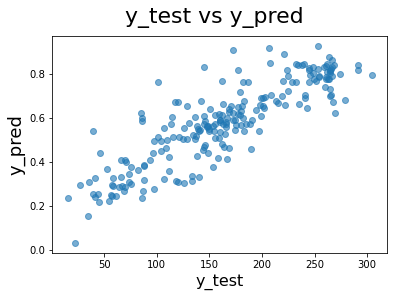

In [50]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_BoomBikes_test, y_BoomBikes_pred, alpha=.6)
fig.suptitle('y_test vs y_pred', fontsize = 22)        
plt.xlabel('y_test', fontsize = 16)                         
plt.ylabel('y_pred', fontsize = 18) 
plt.show()

In [51]:
# We can depict a straight line between these. 

In [52]:
y_BoomBikes_train_pred = lr_Model.predict(X_BoomBikes_train_sm)

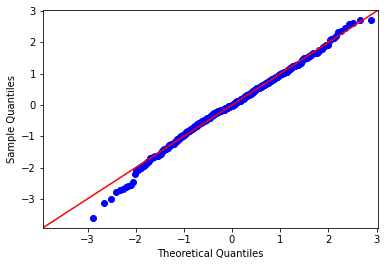

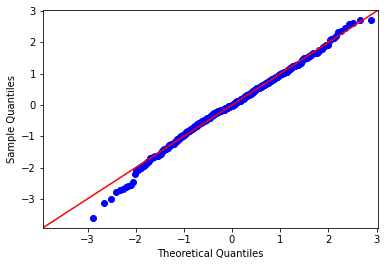

In [53]:
# Plotting qqplot - This elucidates whether the plot distributions of the two variables are equal/similar or not.
residual = y_BoomBikes_train - y_BoomBikes_train_pred
sm.qqplot(residual, fit = True, line = '45')

#### Assumptions of Linear Regression

#### Error terms are normally distributed with mean zero

Text(0.5, 6.79999999999999, 'Errors')

<Figure size 432x288 with 0 Axes>

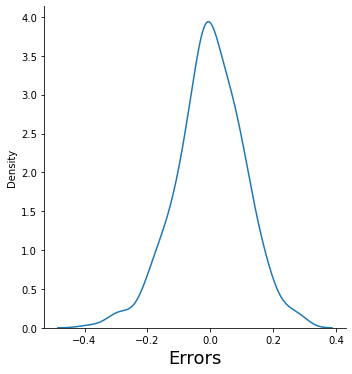

In [54]:
# check if error terms are normally distributed
fig = plt.figure()
sb.displot((residual), kind = 'kde')
fig.suptitle('Error Terms', fontsize = 20)           
plt.xlabel('Errors', fontsize = 18)  

### The error terms are normally distributed. 

#### Check if there is any relationship between x and y

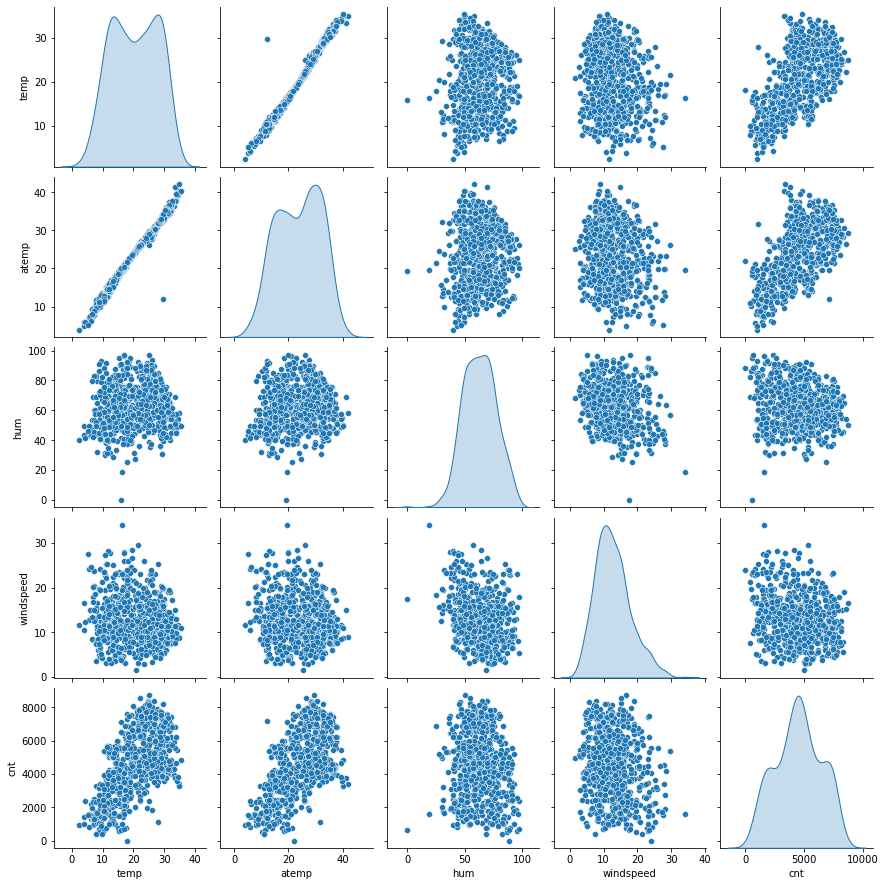

In [55]:
BoomBikesDF= pd.read_csv('day.csv')
BoomBikesDF = BoomBikesDF[[ 'temp', 'atemp', 'hum', 'windspeed','cnt']]
sb.pairplot(BoomBikesDF, diag_kind='kde')
plt.show()

#### temp and atemp are linear in distribution as we can observe a nice straight line.

#### r2 score

In [56]:
from sklearn.metrics import r2_score
y_BoomBikes_train_pred = lr_Model.predict(X_BoomBikes_train_sm)
r2 = r2_score(y_BoomBikes_train, y_BoomBikes_train_pred)
r2

0.7624901904676393

#### Adjusted R2 score

In [57]:
# n is number of rows in X

n = X_BoomBikes_train.shape[0]


# Number of features (predictors, p) is the shape along axis 1
p = X_BoomBikes_train.shape[1]

# We find the Adjusted R-squared using the formula

adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adjusted_r2

0.7582235471826269

## Result Analysis

The most important features for this problem is temperature, season, weathersit, windspeed, year, month. It is observed that demand exceeds in month 9, month 11, month 12. Temperature is the main factor here as when we add this variable in the model, the R2 score increases rapidly. Holiday is also an important contributing factor as people tend to buy bikes during holidays. Windspeed is also taken into account however it is inversely proportional to the demand. As windspeed increases, demand decreases. As the year increases, the bike demand increases. 